In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [11]:
N = 6
# Testing vector
X = np.reshape(np.random.rand(3 * N), (N, 3))
bars = np.zeros((N, N))
cables = np.zeros((N, N))

bars[0,1] = 0.5
bars[1, 3] = 0.5
cables[2,3] = 0.5
bars[2, 4] = 0.5
cables[4,5] = 0.5
bars[0,5] = 0.5

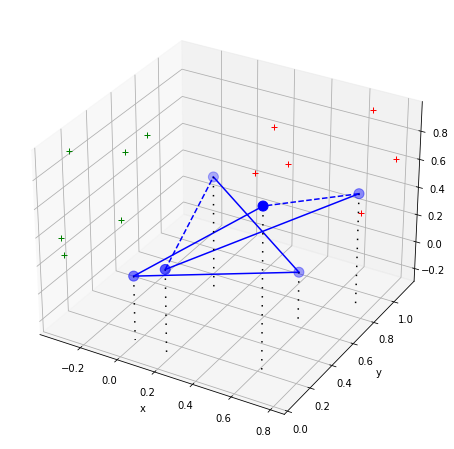

In [12]:
def plot_points(X, bars, cables):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(projection = '3d')
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    xmin, xmax = np.min(X[:,0]), np.max(X[:,0])
    ymin, ymax = np.min(X[:,1]), np.max(X[:,1])
    zmin, zmax = np.min(X[:,2]), np.max(X[:,2])

    ax.scatter(x, y, z, s = 100, c = 'blue')

    ax.plot(x, z, 'r+', zdir='y', zs = ymax + (ymax-ymin) / 2)
    ax.plot(y, z, 'g+', zdir='x', zs= xmin - (xmax-xmin) / 2)
    #ax.plot(x, y, 'k+', zdir='z', zs= zmin - (zmax-zmin) / 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    cable_indices = np.asarray(np.where(cables != 0))
    for i, j in cable_indices.T:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 'b--')

    bar_indices = np.asarray(np.where(bars != 0))
    for i, j in bar_indices.T:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 'b-')

    # Projection down on z
    for i in range(len(z)):
        ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], zmin - (zmax-zmin) / 2], linestyle = (0, (1, 5)), color = 'black')
    plt.show() 

plot_points(X, bars, cables)

## Energy functions

In [13]:
g = 9.81
def E_ext(X, ms):
    return g * np.sum(ms * X[:, 2])

rho = 1
c = 1
def E_bar(X, bars):
    bars_indices = np.asarray(np.where(bars != 0))
    grav = 0
    elast = 0
    for i, j in bars_indices.T:
        grav += bars[i, j] * (X[i, 2] + X[j, 2])
        elast += (np.linalg.norm(X[i] - X[j]) - bars[i, j])**2 / bars[i, j]**2
    return rho * g * grav / 2 + c / 2 *  elast

k = 1
def E_cable(X, cables):
    cables_indices = np.asarray(np.where(cables != 0))
    energy = 0
    for i, j in cables_indices.T:
        if np.linalg.norm(X[i] - X[j]) > cables[i, j]:
            energy += (np.linalg.norm(X[i] - X[j]) - cables[i, j])**2 / cables[i, j]**2
    return energy * k / 2 

def E(X, cables, bars, ms):
    Y = X.reshape(len(ms), 3)
    return E_ext(Y, ms) + E_bar(Y, bars) + E_cable(Y, cables)

# Test
ms = np.ones(N)
print(E(X, cables, bars, ms))

38.4234329657814


In [14]:
a = np.arange(9).reshape((3,3))
print(a)
print(a.flatten())
print(a.flatten()[2::3])

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[0 1 2 3 4 5 6 7 8]
[2 5 8]


### Derivative of energy functions

In [61]:
def dE_ext(X, ms, P, N, M):
    deriv = np.zeros(3 * (N - M))
    deriv[2::3] = ms[M:]
    return g * deriv.flatten()
#np.concatenate((np.zeros((N, 2)), ms)).flatten()

def dE_bar(X, bars, P, N, M):
    bars_indices = np.asarray(np.where(bars != 0))
    grav = np.zeros((N - M, 3))
    elast = np.zeros((N - M, 3))
    
    for i, j in bars_indices.T:
        if i >= M:
            print(i, j)
            norm = np.linalg.norm(X[i-M] - X[j-M])
            grav[i - M] += np.array([0, 0, bars[i, j]])
            grav[j - M] += np.array([0, 0, bars[i, j]])
            elast[i - M] += (norm - bars[i, j]) / (bars[i, j]**2 * norm) * np.array([X[i - M, 0] - X[j - M, 0], X[i - M, 1] - X[j - M, 1], X[i - M, 2] - X[j - M, 2]])
            elast[j - M] += (norm - bars[i, j]) / (bars[i, j]**2 * norm) * np.array([-X[i - M, 0] + X[j - M, 0], -X[i - M, 1] + X[j - M, 1], -X[i - M, 2] + X[j - M, 2]])
        elif j >= M:
            norm = np.linalg.norm(P[i] - X[j-M])
            elast[j-M] += (norm - bars[i, j]) / (bars[i, j]**2 * norm) * np.array([-P[i, 0] + X[j-M, 0], -P[i, 1] + X[j-M, 1], -P[i, 2] + X[j-M, 2]])

    return rho * g * grav.flatten() / 2 + c *  elast.flatten()

def dE_cable(X, cables, P, N, M):
    cable_indices = np.asarray(np.where(cables != 0))
    elast = np.zeros((N - M, 3))

    for i, j in cable_indices.T:
        if i >= M:
            norm = np.linalg.norm(X[i-M] - X[j-M])
            if norm > cables[i, j]:
                elast[i-M] += (norm - cables[i, j]) / (cables[i, j]**2 * norm) * np.array([X[i-M, 0] - X[j-M, 0], X[i-M, 1] - X[j-M, 1], X[i-M, 2] - X[j-M, 2]])
                elast[j-M] += (norm - cables[i, j]) / (cables[i, j]**2 * norm) * np.array([-X[i-M, 0] + X[j-M, 0], -X[i-M, 1] + X[j-M, 1], -X[i-M, 2] + X[j-M, 2]])
        elif j >= M:
            norm = np.linalg.norm(P[i] - X[j-M])
            if norm > cables[i, j]:
                elast[j-M] += (norm - cables[i, j]) / (cables[i, j]**2 * norm) * np.array([-P[i, 0] + X[j-M, 0], -P[i, 1] + X[j-M, 1], -P[i, 2] + X[j-M, 2]])
    return k * elast.flatten()

def dE(X, P, cables, bars, ms, N, M):
    Y = X.reshape(N - M, 3)
    gradient = (dE_ext(Y, ms, P, N, M) + dE_bar(Y, bars, P, N, M) + dE_cable(Y, cables, P, N, M))
    #print("Ext ",dE_ext(Y, ms, P, N, M))
    #print("Bar ", dE_bar(Y, bars, P, N, M))
    #print("Cable", dE_cable(Y, cables, P, N, M))
    return gradient
M = 3
print(dE(X[M:], X[:M], cables, bars, ms, N, M))

[-0.51971386  0.36491606 10.40886408  1.24005633  2.10664489  9.91139453
  0.98564513 -0.61881448 11.40722529]


In [62]:
def armijo(x, alpha, p, c1, f, df):
    return f(x + alpha * p) <= f(x) + c1 * alpha * np.inner(df(x), p)

def curvature(x, alpha, p, c2, df):
    return -np.inner(df(x + alpha * p), p) <= -c2 * np.inner(df(x), p)

def backtracking(x, p, c1, c2, f, df):
    assert(c1 < c2)
    alpha_min, alpha_max = 0, np.inf
    alpha = 1
    I = armijo(x, alpha, p, c1, f, df)
    II = curvature(x, alpha, p, c2, df)
    while not (I and II):
        if not I:
            alpha_max = alpha
            alpha = (alpha_min + alpha_max) / 2
        else:
            alpha_min = alpha
            if alpha_max < np.inf:
                alpha = (alpha_min + alpha_max) / 2
            else:
                alpha *= 2
        I = armijo(x, alpha, p, c1, f, df)
        II = curvature(x, alpha, p, c2, df)
        print(alpha, I, II)
    return alpha

In [68]:
def BFGS(X0, N, M, cables, bars, ms, maxiter):
    P = X0[:3 * M]
    Y0 = X0[3 * M:]
    def f(y):
        X = np.concatenate((P, y))
        return E(X, cables, bars, ms)

    def df(y):
        return dE(y, P.reshape(M, 3), cables, bars, ms, N, M)

    c1, c2 = 0.1, 0.6
    # First: Gradient descent
    p = -df(Y0)
    alpha = backtracking(Y0, p, c1, c2, f, df)
    Y1 = Y0 + alpha * p

    sk = Y1 - Y0
    yk = df(Y1) - df(Y0)
    H = np.inner(yk, sk) / np.inner(yk, yk) * np.eye(3 * (N - M))

    for k in range(maxiter):
        sk = Y1 - Y0
        yk = df(Y1) - df(Y0)
        Hkyk = H@yk
        Sk = 1 / np.inner(sk, yk)
        H = H - Sk * (sk @ Hkyk.T + Hkyk @ sk.T) + sk @ sk.T * (Sk**2 * np.inner(yk, Hkyk) + Sk)
        p = -H @ df(Y1)
        alpha = backtracking(Y1, p, c1, c2, f, df)
        Y0 = Y1
        Y1 = Y0 + alpha * p
        
    

M = 3
BFGS(X.flatten(), N, M, cables, bars, ms, 10)

0.5 True True
0.5 True True
0.5 False True
0.25 False True
0.125 False True
0.0625 False True
0.03125 False True
0.015625 False True
0.0078125 False True
0.00390625 False True
0.001953125 False True
0.0009765625 False True
0.00048828125 False True
0.000244140625 False True
0.0001220703125 False True
6.103515625e-05 False True
3.0517578125e-05 False True
1.52587890625e-05 False True
7.62939453125e-06 False True
3.814697265625e-06 False True
1.9073486328125e-06 False True
9.5367431640625e-07 False True
4.76837158203125e-07 False True
2.384185791015625e-07 False True
1.1920928955078125e-07 False True
5.960464477539063e-08 False True
2.9802322387695312e-08 False True
1.4901161193847656e-08 False True
7.450580596923828e-09 False True
3.725290298461914e-09 False True
1.862645149230957e-09 False True
9.313225746154785e-10 False True
4.656612873077393e-10 False True
2.3283064365386963e-10 False True
1.1641532182693481e-10 False True
5.820766091346741e-11 False True
2.9103830456733704e-11 False

KeyboardInterrupt: 